Below will be some code to calculate k-corrections for clusters in the Molino HST Cluster catalogs, following their example

In [1]:
import numpy as np
import pandas as pd
import kcorrect 
import kcorrect.utils as ut
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import os
from itertools import combinations

In [19]:
def make_kcorr_filt_template(dataframe):
    '''This task will make a kcorrect filter template from a dataframe that optimizes the number of objects with detections in a subset of filters. In this case the dataframe should contain cfht, subaru, and irac wideband filters. '''
    kcordir=os.environ["KCORRECT_DIR"]
    clash_to_kcorr={'F225W_WFC3_MASS':'clash_wfc3_f225w.par','F275W_WFC3_MASS':'clash_wfc3_f275w.par','F336W_WFC3_MASS':'clash_wfc3_f336w.par','F390W_WFC3_MASS':'clash_wfc3_f390w.par','F435W_ACS_MASS':'clash_acs_f435w.par','F475W_ACS_MASS':'clash_acs_f475w.par','F606W_ACS_MASS':'clash_acs_f606w.par','F625W_ACS_MASS':'clash_acs_f625w.par','F775W_ACS_MASS':'clash_acs_f775w.par','F814W_ACS_MASS':'clash_acs_f814w.par','F850LP_ACS_MASS':'clash_acs_f850lp.par','F105W_WFC3_MASS':'clash_wfc3_f105w.par','F110W_WFC3_MASS':'clash_wfc3_f110w.par','F125W_WFC3_MASS':'clash_wfc3_f125w.par','F140W_WFC3_MASS':'clash_wfc3_f140w.par','F160W_WFC3_MASS':'clash_wfc3_f160w.par'}
    numb1=0
    numb2=0
    numb3=0
    numb4=0
    numb5=0
    flist1=[]
    flist2=[]
    flist3=[]
    flist4=[]
    flist5=[]
    ilist1=[]
    ilist2=[]
    ilist3=[]
    ilist4=[]
    ilist5=[]
    kcor_template=kcordir+'/data/templates/temp_file_list.dat'
    for x in combinations(list(dataframe),7):
        if len(dataframe[(dataframe[x[0]]<40)&(dataframe[x[1]]<40)&(dataframe[x[2]]<40)&(dataframe[x[3]]<40)&(dataframe[x[4]]<40)]) > numb1:
            ilist5=ilist4
            ilist4=ilist3
            ilist3=ilist2
            ilist2=ilist1
            ilist1=dataframe[(dataframe[x[0]]<40)&(dataframe[x[1]]<40)&(dataframe[x[2]]<40)&(dataframe[x[3]]<40)&(dataframe[x[4]]<40)].index.tolist()
            numb5=numb4
            numb4=numb3
            numb3=numb2
            numb2=numb1
            numb1=len(ilist1)
            flist5=flist4
            flist4=flist3
            flist3=flist2
            flist2=flist1
            flist1=x
    print(len(dataframe))
    print(numb1)
    with open(kcor_template,'w') as file:
        file.write('KCORRECT_DIR\n')
        for filt in flist1:
            file.write('data/filters/'+clash_to_kcorr[filt]+'\n')
    return flist1,kcor_template

In [3]:
kcorr_dir=os.environ["KCORRECT_DIR"]

In [4]:
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)

In [5]:
infile='/Users/lucashunt/ASTRODATA/LCBG_IN_CLUSTERS/catalogs/hlsp_clash_hst_ir_macs0717_cat-molino.txt'
dataset=pd.read_table(infile,delim_whitespace=True,header=133)
cluster_member_photometry=dataset[(dataset.zb_1<dataset.clusterz+0.2)&(dataset.zb_1>dataset.clusterz-0.2)]

The next line reads the catalog into a pandas dataframe. Whitespace=True sets the delimiter (separator) as whitespace, and header=133 sets the line that contains header information. This line is the one that labels each column correctly in this document. The final line selects objects that have a photometric redshift within the cluster redshift range

In [20]:
filt_list,filt_file=make_kcorr_filt_template(cluster_member_photometry[[f for f in list(cluster_member_photometry) if ('MASS' in f) & ('d' not in f) & ('LensCor' not in f)]])

KeyboardInterrupt: 

In [7]:
filt_file

'/Users/lucashunt/programs/kcorrect/data/templates/temp_file_list.dat'

In [8]:
filt_list

('F775W_ACS_MASS',
 'F814W_ACS_MASS',
 'F850LP_ACS_MASS',
 'F110W_WFC3_MASS',
 'F125W_WFC3_MASS',
 'F140W_WFC3_MASS',
 'F160W_WFC3_MASS')

This line selects only ID, photometry, and redshift columns

In [9]:
cluster_member_photometry=cluster_member_photometry.reset_index().drop(columns='index')

Below create a copy to generate maggies and select objects that actually have photometry

In [11]:
for string in [s + '_maggies' for s in filt_list]:
    cluster_member_photometry[string]=np.nan
    
for string in [s + '_invervar' for s in filt_list]:
    cluster_member_photometry[string]=np.nan

numbers=np.arange(1,7,1)

for string in ['c'+str(number) for number in numbers]:
    cluster_member_photometry[string]=np.nan
    
for string in [s + '_synthetic' for s in filt_list]:
    cluster_member_photometry[string]=np.nan

In [12]:
columns=list(cluster_member_photometry)
for column in columns:
    if 'maggies' in column:
        cluster_member_photometry[column]=ut.mag2maggies(cluster_member_photometry[column.split('_maggies')[0]])
        cluster_member_photometry[column.split('_maggies')[0]+'_invervar']=ut.invariance(cluster_member_photometry['d'+column.split('_maggies')[0]],cluster_member_photometry[column])

In [13]:
cmm_ind=cluster_member_photometry.index.values

In [14]:
kcorrect.load_templates()
kcorrect.load_filters(filt_file)

In [15]:
for i in cmm_ind:
	cluster_member_photometry.loc[i,'c1':'c6']=kcorrect.fit_nonneg(np.array(cluster_member_photometry.loc[i,'zb_1'],dtype=float),np.array(cluster_member_photometry.loc[i,[col+'_maggies' for col in filt_list]],dtype=float),np.array(cluster_member_photometry.loc[i,[col+'_maggies' for col in filt_list]],dtype=float))


In [16]:
for i in cmm_ind:
    cluster_member_photometry.loc[i,[col for col in cluster_member_photometry.columns if 'synthetic' in col]]=kcorrect.reconstruct_maggies(cluster_member_photometry.loc[i,'c1':'c6'])[1:]


In [17]:
cluster_member_photometry['U0_synthetic']=np.nan
cluster_member_photometry['B0_synthetic']=np.nan
cluster_member_photometry['V0_synthetic']=np.nan

In [18]:
kcorrect.load_templates()
kcorrect.load_filters(kcorr_dir+'/data/templates/bessell_ubv.dat')

In [19]:
rmarr0UBV=np.ndarray((len(cluster_member_photometry),4))

In [20]:
cluster_member_photometry[['c1','c2','c3','c4','c5','c6']].loc[i]

c1     0.341000
c2     4.050985
c3     0.051827
c4     0.000003
c5     0.173564
c6    14.872971
Name: 888, dtype: float64

In [21]:
for i in cmm_ind:
    cluster_member_photometry.loc[i,["U0_synthetic","B0_synthetic","V0_synthetic"]]=kcorrect.reconstruct_maggies(cluster_member_photometry[['c1','c2','c3','c4','c5','c6']].loc[i],redshift=0)[1:]

In [22]:
columns=list(cluster_member_photometry)
cluster_member_photometry.loc[:,[col for col in columns if 'synthetic' in col]]=-2.5*np.log10(cluster_member_photometry.loc[:,[col for col in columns if 'synthetic' in col]])

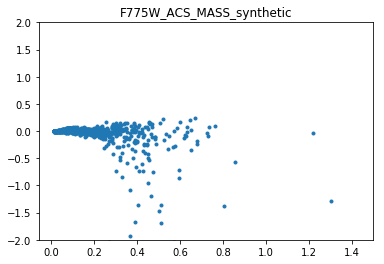

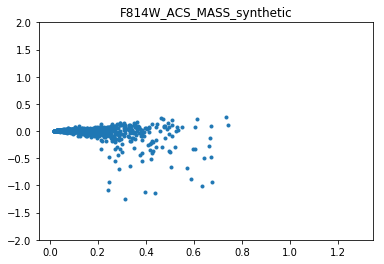

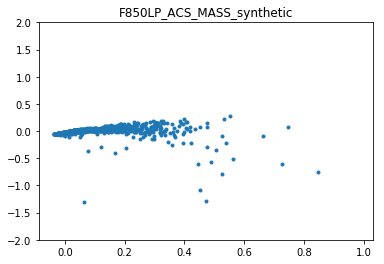

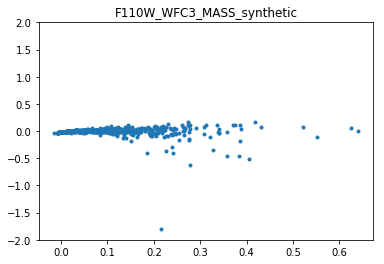

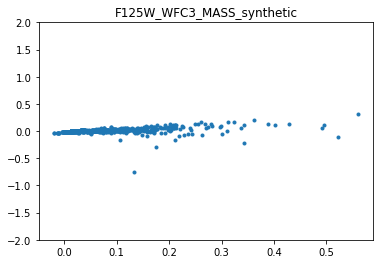

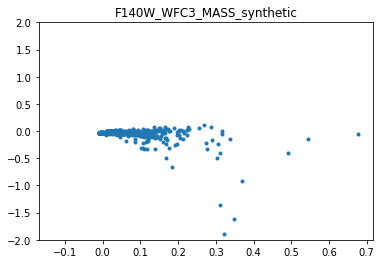

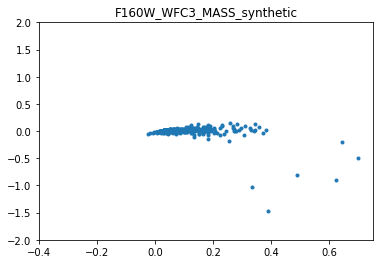

In [23]:
i=0
for col in [col for col in columns if ('synthetic' in col) & ('F' in col)]:
    i=i+1
    plt.figure(i)
    plt.plot(cluster_member_photometry.loc[:,col],cluster_member_photometry.loc[:,col]-cluster_member_photometry.loc[:,col.split('_synthetic')[0]],'.')
    plt.ylim(-2,2)
    plt.title(col)

In [24]:
cluster_member_photometry['U0_synthetic']=cluster_member_photometry['U0_synthetic']-0.79
cluster_member_photometry['B0_synthetic']=cluster_member_photometry['B0_synthetic']+0.09
cluster_member_photometry['V0_synthetic']=cluster_member_photometry['V0_synthetic']-0.02

In [25]:
cluster_member_photometry['Abs_U0']=cluster_member_photometry['U0_synthetic']-cosmo.distmod(cluster_member_photometry['zb_1']).value
cluster_member_photometry['Abs_B0']=cluster_member_photometry['B0_synthetic']-cosmo.distmod(cluster_member_photometry['zb_1']).value
cluster_member_photometry['Abs_V0']=cluster_member_photometry['V0_synthetic']-cosmo.distmod(cluster_member_photometry['zb_1']).value

Text(0,0.5,'(U-B)$_{0}$')

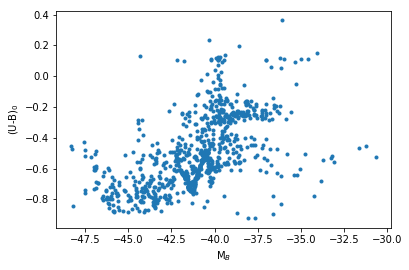

In [26]:
plt.plot(cluster_member_photometry.Abs_B0,cluster_member_photometry.Abs_U0-cluster_member_photometry.Abs_B0,'.')
plt.xlabel('M$_{B}$')
plt.ylabel('(U-B)$_{0}$')

In [27]:
writer=pd.ExcelWriter('/Users/lucashunt/ASTRODATA/LCBG_IN_CLUSTERS/catalogs/CLASH_CLUSTER_MEMBER_FILTERS_0717.xlsx',engine='xlsxwriter')
cluster_member_photometry.to_excel(writer)
writer.save()
cluster_member_photometry.to_csv('/Users/lucashunt/ASTRODATA/LCBG_IN_CLUSTERS/catalogs/macs0717_kcorrected_molino_cat.txt')